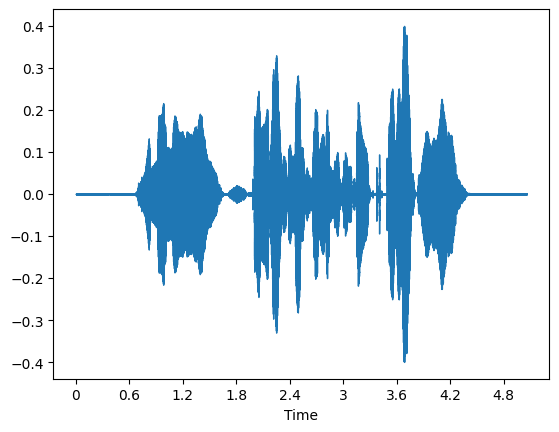

In [1]:
import librosa
import matplotlib.pyplot as plt

f = 'mnt/gcs-bucket/data/F2001/F2001_000001.wav'
y, sr = librosa.load(f)

librosa.display.waveshow(y, sr=sr)

echo "deb http://packages.cloud.google.com/apt gcsfuse-$(lsb_release -c -s) main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
sudo apt update
sudo apt install gcsfuse
sudo gcsfuse -o allow_other --implicit-dirs voicemodel mnt/gcs-bucket


In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

GPU is available
GPU device name: Tesla T4


In [ ]:
import os
import torch
import soundfile as sf
import librosa
import pandas as pd
from transformers import HubertForSequenceClassification, Wav2Vec2Processor, Trainer, TrainingArguments
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")  # 모든 경고 숨기기

# Helper function to split dataset into smaller batches
def split_dataset(dataset, num_splits):
    split_size = len(dataset) // num_splits
    splits = [torch.utils.data.Subset(dataset, list(range(i * split_size, (i + 1) * split_size))) for i in range(num_splits)]
    remainder = len(dataset) % num_splits
    if remainder:
        splits[-1] = torch.utils.data.ConcatDataset([splits[-1], torch.utils.data.Subset(dataset, list(range(num_splits * split_size, len(dataset))))])
    return splits

torch.cuda.empty_cache()

# 1. CSV 파일 로드 및 전처리 (None 값 제거)
csv_file_path = '/home/mywinningtime/labeling.csv'
df = pd.read_csv(csv_file_path).dropna(subset=['감정'])  # None 값 제거

# 감정 레이블 정의 및 매핑
emotion_labels = df['감정'].unique().tolist()
label2id = {str(emotion): int(i) for i, emotion in enumerate(emotion_labels)}
id2label = {int(i): str(emotion) for i, emotion in enumerate(emotion_labels)}

# 2. 음성 파일 로드 함수 정의
def load_audio(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    speech, rate = sf.read(file_path)
    if rate != 16000:  # 16000Hz로 리샘플링
        speech = librosa.resample(speech, orig_sr=rate, target_sr=16000)
    return speech

# 3. SpeechDataset 클래스 정의
class SpeechDataset(Dataset):
    def __init__(self, df, base_directory, folders):
        self.base_directory = base_directory
        self.folders = folders

        # 모든 폴더를 탐색하며 CSV 파일 정보와 매칭
        self.data = []
        for folder_name in folders:
            folder_path = os.path.join(base_directory, folder_name)
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".wav"):
                    # 파일명에서 숫자 부분 추출 (예: M2001_000001.wav -> 000001)
                    file_number = int(file_name.split('_')[-1].replace(".wav", ""))
                    
                    # CSV 파일에서 '연번' 열과 일치하는 행 찾기
                    matching_rows = df[df['연번'] == file_number]
                    if not matching_rows.empty:
                        emotion = matching_rows.iloc[0]['감정']
                        label = label2id[emotion]
                        
                        # 데이터 리스트에 경로와 레이블 추가
                        self.data.append({
                            'file_path': os.path.join(folder_path, file_name),
                            'label': label
                        })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 파일 경로와 레이블 가져오기
        file_path = self.data[idx]['file_path']
        label = self.data[idx]['label']

        # 음성 파일 로드 및 전처리
        speech = load_audio(file_path)
        inputs = feature_extractor(speech, sampling_rate=16000, return_tensors="pt", padding=True)

        return {
            "input_values": inputs.input_values[0],
            "attention_mask": inputs.attention_mask[0] if "attention_mask" in inputs else None,
            "labels": torch.tensor(label, dtype=torch.long),
        }

# 4. collate_fn 정의: 배치 생성 시 입력을 동일한 길이로 패딩
def collate_fn(batch):
    input_values = [item["input_values"] for item in batch]
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)
    input_values_padded = pad_sequence(input_values, batch_first=True, padding_value=0.0)
    attention_mask = (input_values_padded != 0).long()

    return {
        "input_values": input_values_padded,
        "attention_mask": attention_mask,
        "labels": labels,
    }

# 5. 평가 메트릭 함수 정의
def compute_metrics(pred):
    # predictions가 튜플로 반환되면 첫 번째 요소(logits)만 사용
    logits = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
    preds = logits.argmax(-1)  # 가장 높은 로짓 값의 인덱스가 예측 값
    acc = accuracy_score(pred.label_ids, preds)  # 정확도 계산
    return {"accuracy": acc}
    
# 6. 데이터셋 및 DataLoader 준비
audio_directory = "mnt/gcs-bucket/data/"

# 모든 M으로 시작하는 폴더 가져오기
def get_folders_with_prefix(base_directory, prefix="M"):
    folders = [
        folder for folder in os.listdir(base_directory) 
        if os.path.isdir(os.path.join(base_directory, folder)) and folder.startswith(prefix)
    ]
    return sorted(folders)  # 정렬된 순서로 반환

all_folders = get_folders_with_prefix(audio_directory)

# Train/Test 분할 (80%: Train, 20%: Test)
train_folders, test_folders = train_test_split(all_folders, test_size=0.2, random_state=42)

train_dataset = SpeechDataset(df, audio_directory, train_folders)
test_dataset = SpeechDataset(df, audio_directory, test_folders)

# Train/Test 데이터셋을 24개로 분할
train_subsets = split_dataset(train_dataset, 36)
test_subsets = split_dataset(test_dataset, 36)

# 각 Train/Test 서브셋에 대해 학습 및 평가 진행
for i, (train_subset, test_subset) in enumerate(zip(train_subsets, test_subsets)):
    torch.cuda.empty_cache()
    print(f"Training on subset {i + 1}/36")
    train_loader = DataLoader(train_subset, batch_size=8, collate_fn=collate_fn, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=8, collate_fn=collate_fn)

    # 모델 및 프로세서 설정 (hubert-base-superb-er 사용)
    model = HubertForSequenceClassification.from_pretrained(
        "superb/hubert-base-superb-er",
        num_labels=len(emotion_labels),  # 6개 클래스 (현재 CSV의 클래스 개수에 맞춰 조정)
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True  # 크기 불일치 무시
    )

    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-base-superb-er")

    # 훈련 설정
    training_args = TrainingArguments(
        output_dir=f"./results/subset_{i+1}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,  # 배치 크기 조정
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        gradient_accumulation_steps=1,  # 그라디언트 누적 단계 설정 감소
        fp16=True 
    )

    # Trainer 설정
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_subset,
        eval_dataset=test_subset,
        tokenizer=feature_extractor,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    # 모델 학습
    trainer.train()

    # 테스트 평가
    results = trainer.evaluate()
    print(f"Test Results for subset {i + 1}: {results}")
    


Training on subset 1/36


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mywinningtime/myenv/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  w

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.768439,0.235294
2,No log,1.724142,0.270588
3,No log,1.701403,0.264706


/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Results for subset 1: {'eval_loss': 1.7241419553756714, 'eval_accuracy': 0.27058823529411763, 'eval_runtime': 9.9027, 'eval_samples_per_second': 17.167, 'eval_steps_per_second': 1.111, 'epoch': 3.0}
Training on subset 2/36


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mywinningtime/myenv/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  w

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.774639,0.352941
2,No log,1.739252,0.352941
3,No log,1.746170,0.276471


/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Results for subset 2: {'eval_loss': 1.7746394872665405, 'eval_accuracy': 0.35294117647058826, 'eval_runtime': 8.4535, 'eval_samples_per_second': 20.11, 'eval_steps_per_second': 1.301, 'epoch': 3.0}
Training on subset 3/36


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mywinningtime/myenv/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/mywinningtime/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  w

Epoch,Training Loss,Validation Loss
